# Feature description
<p>
    Image source: <a href="https://www.researchgate.net/figure/261995555_fig3_Emotiv-EEG-neuroheadset-sensor-position-and-corresponding-behavior-groups-AF3-AF4-FC5">here</a> 
</p>

<div>
    <img src="EEGSensorPosition.png" width="50%" align="left" />

    <p><b>Features:</b></p>
    <ul style="float: left; margin-left: 10px;">
        <li>AF3</li>
        <li>F7</li>
        <li>F3</li>
        <li>FC5</li>
        <li>T7</li>
        <li>P7</li>
        <li>O1</li>
        <li>O2</li>
        <li>P8</li>
        <li>T8</li>
        <li>FC6</li>
        <li>F4</li>
        <li>F8</li>
        <li>AF4</li>
    </ul>
</div>


In [1]:
%reset -f

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

featureCount = 14
outputIndex = 14

%matplotlib inline

In [2]:
# Load EEG data
eegData = np.genfromtxt('EEGEyeState.arff.csv', delimiter=',', skip_header=1)
eegHeader = np.genfromtxt('EEGEyeState.arff.csv', delimiter=',', max_rows=1, dtype=str)

countDataPoints = eegData.shape[0]
countFeatures = eegData.shape[1] - 1 # Excluding the output vector

## Correlation matrix

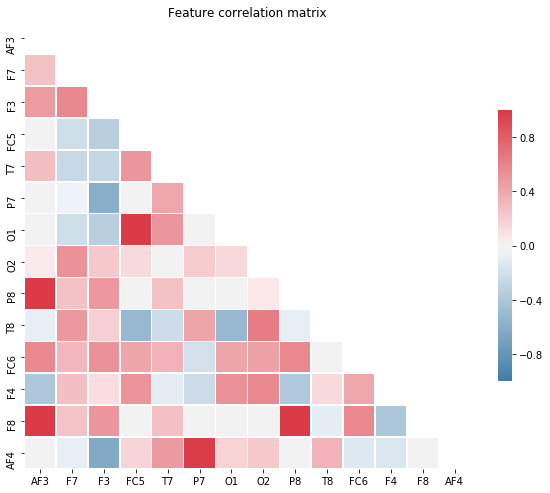

In [3]:
# EEG data frame
eegDF = pd.DataFrame(data=eegData[:, 0:featureCount],
                 columns=list(eegHeader[0:featureCount]))

# Compute the correlation matrix
corr = eegDF.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Feature correlation matrix")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Store the upper triangle of the correlation matrix into an Excel sheet
corrUpperTri = corr.where(mask)
writer = pd.ExcelWriter('EEGCorrelation.xlsx')
corrUpperTri.to_excel(writer, 'CorrelationMatrix')
writer.save()

## Output classifier - Time series

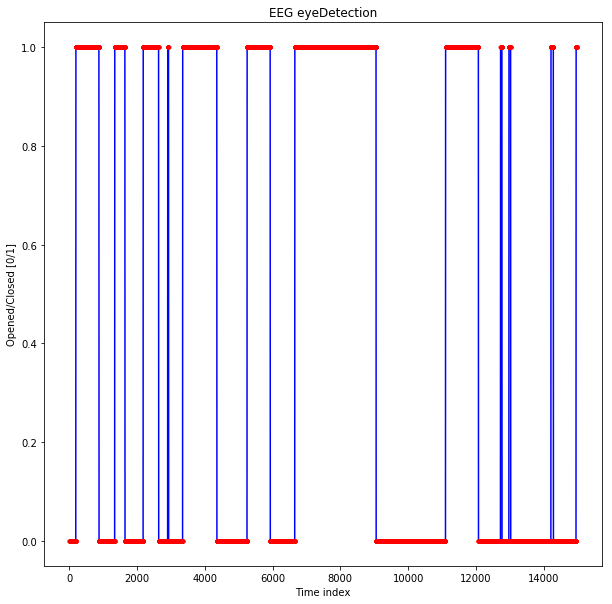

In [4]:
# Set up the matplotlib figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

ax = fig.add_subplot(1, 1, 1)
ax.set_title("EEG eyeDetection")
ax.set_xlabel("Time index")
ax.set_ylabel("Opened/Closed [0/1]")

# Plot the output variable against time
suppressOut = ax.plot(eegData[:, 14], 'b')
suppressOut = ax.plot(eegData[:, 14], 'r.')

## Helper methods
#### plotBoxPlots
- Helper method for plotting box plots
- Figure 1 --> Box plot whiskers represent the full range (min - max)
- Figure 2 --> Box plot whiskers represent the 5% - 95% range

#### plotMeans
- Helper method for plotting a scatter plot of the mean input features, based on their classified output

In [5]:
def plotBoxPlots(data, arrLabels, titleSuffix):
    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(15)
    
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title('Feature range: full - ' + titleSuffix)
    suppress = ax1.boxplot(data
                          , sym='b.'
                          , vert=False
                          , whis='range'
                          , labels=arrLabels
                          , meanline=True
                          , showbox=True
                          , showfliers=True
                      )
    
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title('Feature range: [5%, 95%] - ' + titleSuffix)
    suppress = ax2.boxplot(data
                          , sym='b.'
                          , vert=False
                          , whis=[5, 95]
                          , labels=arrLabels
                          , meanline=True
                          , showbox=True
                          , showfliers=False
                      )

def plotMeans(data, featureCount, outIndex, title):
    idxEyeClosed = np.where(data[:, outIndex] == 1)[0]
    idxEyeOpened = np.where(data[:, outIndex] == 0)[0]

    x = np.array(range(featureCount))
    xTickLabels = eegHeader[0:featureCount]
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(title)
    ax.set_xticklabels(xTickLabels)
    ax.set_xticks(x)
    
    ax.plot(x, data[idxEyeOpened][:, 0:featureCount].mean(axis=0), 'b.')
    ax.plot(x, data[idxEyeClosed][:, 0:featureCount].mean(axis=0), 'r.')
    ax.plot(x, data[:, 0:featureCount].mean(axis=0), 'g.')
    
    ax.legend(['Eye Open', 'Eye Closed', 'Both'])


## Box plots - Raw data

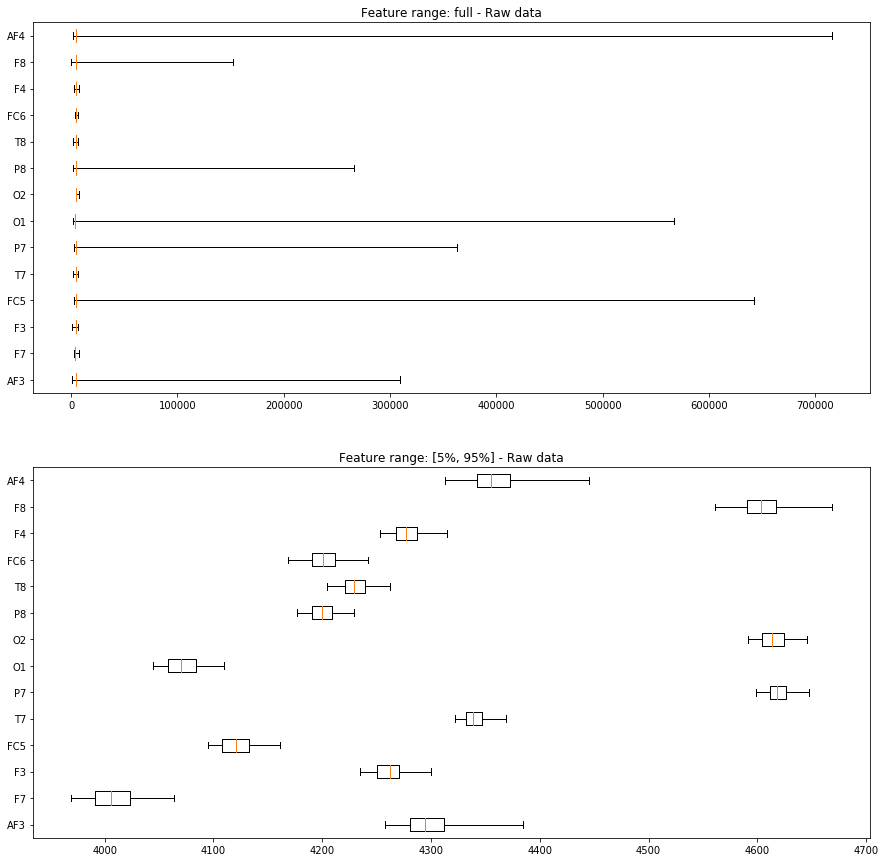

In [6]:
plotBoxPlots(eegData[:, 0:featureCount], eegHeader[0:featureCount], 'Raw data')

## Box plots - Extreme outliers excluded

Extreme outliers
Total:    4 
Indexes:  [898, 10386, 11509, 13179]


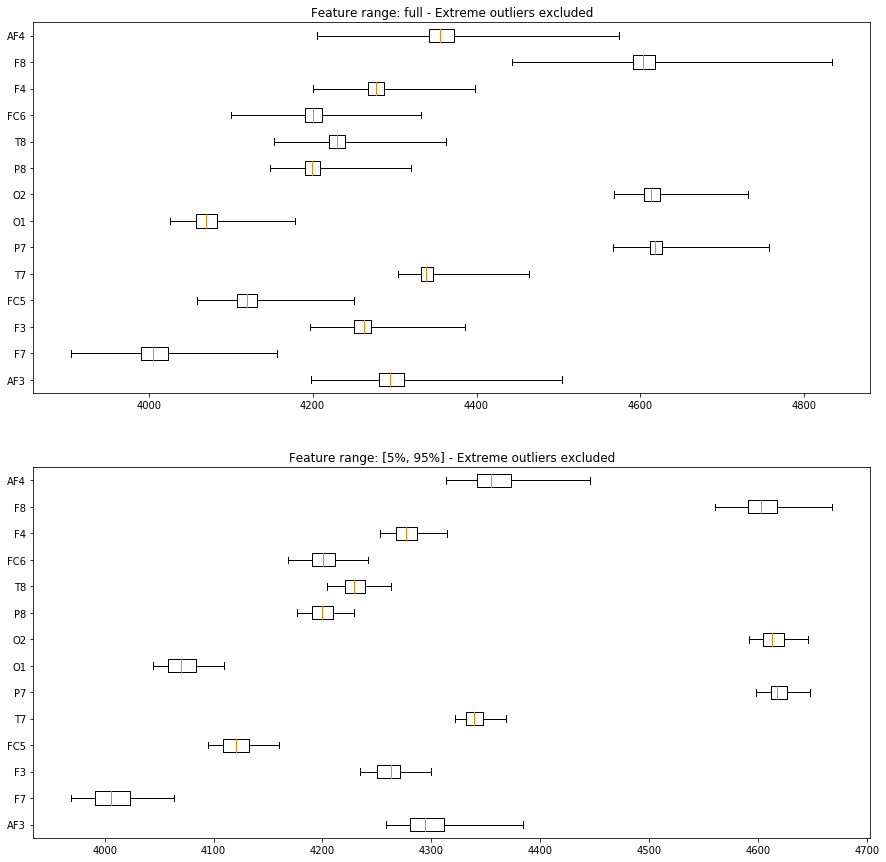

In [7]:
outLierIndexes = set()
upperLimit = 5000

for x in range(featureCount + 1):
    outLiers = np.where(eegData[:, x] > upperLimit)[0]
    if len(outLiers) > 0:
        for i in xrange(len(outLiers)):
            outLierIndexes.add(outLiers[i])

outLierIndexes = list(outLierIndexes)
outLierIndexes.sort()
print 'Extreme outliers\nTotal:   ', len(outLierIndexes), \
    '\nIndexes: ', outLierIndexes

eegDataNoOutLiers = np.delete(eegData, outLierIndexes, 0)
plotBoxPlots(eegDataNoOutLiers[:, 0:featureCount],
             eegHeader[0:featureCount],
             'Extreme outliers excluded')



## Mean scatter plot - Raw data

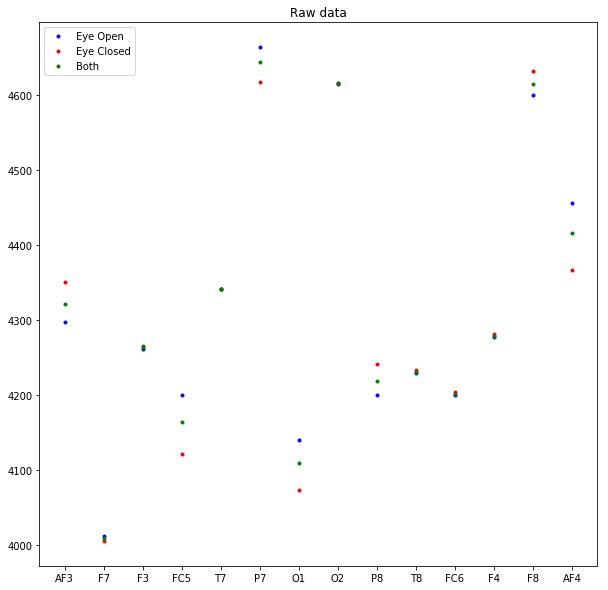

In [8]:
plotMeans(eegData, featureCount, outputIndex, "Raw data")

## Mean scatter plot - Extreme outliers excluded

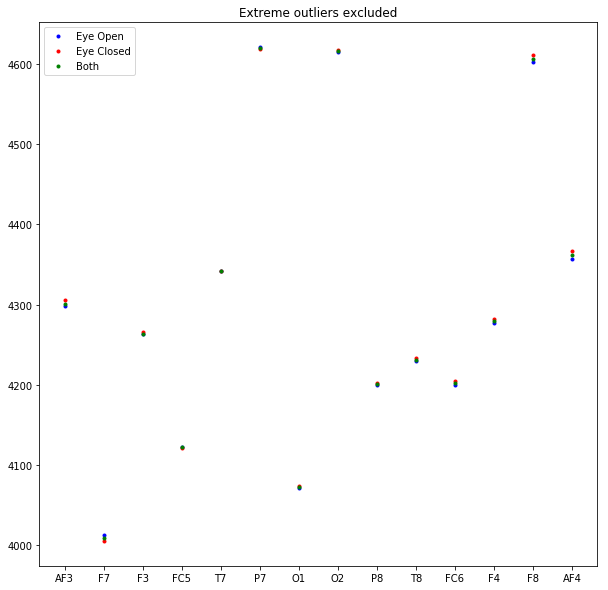

In [9]:
plotMeans(eegDataNoOutLiers, featureCount, outputIndex, "Extreme outliers excluded")